In [25]:
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid
import warpfield
from IPython.display import JSON
import pandas as pd

In [2]:
pn_bg = r"~/hpc-rw/lfm/bg"
for file in pathlib.Path(os.path.expanduser(pn_bg)).iterdir():
    if file.is_file():
        print(file.name)

20250602_1753_LB_bg_200s_100laser_2fps.npy
20250701_1651_LB_bg_40fps.h5
20250602_1749_LB_bg_100s.h5
20250602_1749_LB_bg_100s_100laser_2fps.npy
20250611_1508_LB_80fps_100laser_bg.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.h5
20250602_1753_LB_bg_200s.npy
20250602_1749_LB_bg_100s.npy
20250701_1654_LB_bg_2fps.h5
20250611_1508_LB_40fps_100laser_bg.npy
20250701_1649_LB_bg_80fps.h5
20250701_1654_LB_bg_2fps.npy
20250610_1904_80laser_5fps.npy
20250610_1904_LB_30k_wo_coverslip_1_bg.npy
20250602_1753_LB_bg_200s.h5
20250611_1508_LB_40fps_100laser_bg.h5
20250701_1651_LB_bg_40fps.npy
20250611_1508_LB_80fps_100laser_bg.h5
20250701_1649_LB_bg_80fps.npy


In [3]:
pn_out = r"~/hpc-rw/lfm/results"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_out, '*'))), reverse=True) if os.path.exists(os.path.join(pn_out, rec, 'deconvolved.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250701_1625_LB_ZF_v552_f7_40fps_2
20250701_1622_LB_ZF_v552_f7_40fps_1
20250701_1605_LB_ZF_v552_f6_40fps_1
20250701_1541_LB_ZF_v552_f5_40fps_2
20250701_1538_LB_ZF_v552_f5_40fps_1
20250701_1522_LB_ZF_v552_f4_80fps_1
20250701_1501_LB_ZF_v552_f3_40fps_2
20250701_1438_LB_ZF_v552_f2_40fps_2
20250701_1358_LB_ZF_v552_f1_40fps_2
20250514_1635_LF_ZF552_f4_1_comp_40fps
20250514_1515_LF_ZF552_f1_4_uncomp_40fps
20250513_1351_LB_redFB_1-1k_3d_with_movement


In [4]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1538_LB_ZF_v552_f5_40fps_1"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

In [5]:
#generate default registration recipe
recipe = warpfield.Recipe.from_yaml('default.yml')

### Generate reference volume from recording

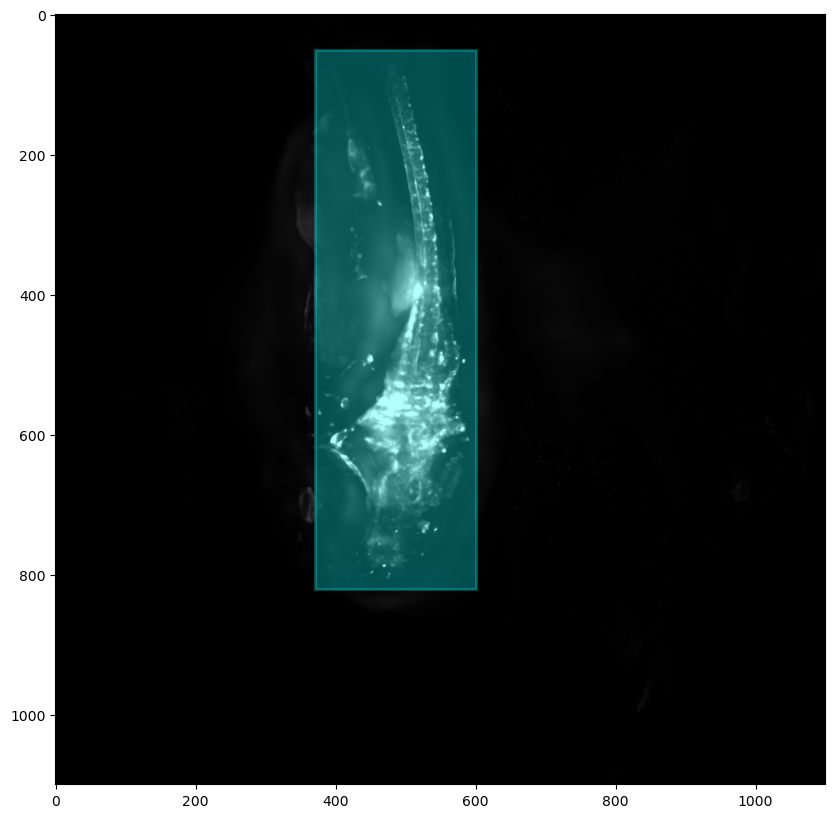

In [6]:
with h5py.File(paths.deconvolved, "r") as f:
    im = np.array(f["data"][0])
x1, y1 = 370, 50
x2, y2 = 600, 820
crop = (y1, y2, x1, x2)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(im.max(axis=0), cmap = "gray", vmax=10)
rect = plt.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="cyan", facecolor="cyan", alpha=0.3
    )
ax.add_patch(rect)
crop = (y1, y2, x1, x2)

In [7]:
import register
importlib.reload(register)
from register import average_volumes



In [8]:
#inspect theindexes to use for generating the refenrence - should be very little movement
ref_idx = [100,120,1]
ref_vol_unreg, video_fn = average_volumes(paths,
                                           ref_idx,
                                           preprocess = lambda x: x[:,crop[0]:crop[1],crop[2]:crop[3]],
                                           vmax=100,
                                           vmin=0,
                                           absolute_limits=False, transpose=True)

showvid(video_fn)

Averaging:   0%|          | 0/20 [00:00<?, ?it/s]

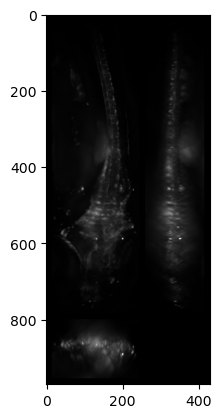

In [9]:
plt.imshow(create_projection_image(ref_vol_unreg, vmax=50, vmin=0, absolute_limits=False), cmap="gray")

In [10]:
#refine reference volume by registering every volume to the average and then averaging again
def register_reference(vol):
    return warpfield.register_volumes(ref_vol_unreg, vol[:,crop[0]:crop[1],crop[2]:crop[3]], recipe)[0]


ref_vol, video_fn = average_volumes(paths,
                                      ref_idx,
                                     preprocess = register_reference,
                                      vmax=100,
                                      vmin=0,
                                      absolute_limits=False,
                                     transpose = True
                                      )

showvid(video_fn)

Averaging:   0%|          | 0/20 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

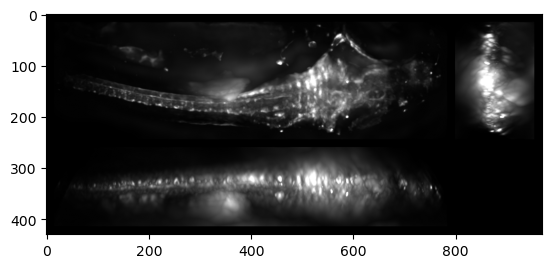

In [11]:
plt.imshow(create_projection_image(ref_vol, vmax=20, vmin=0, absolute_limits=False, transpose=True), cmap="gray")

### Test mini registration

In [16]:
#generate default registration recipe
recipe = warpfield.Recipe.from_yaml('default.yml')




recipe.levels

[LevelConfig(block_size=[-1, -1, -1], block_stride=1.0, project=Projector(max=True, normalize=False, dog=True, low=0.5, high=10.0, periodic_smooth=False), tukey_ref=0.5, smooth=Smoother(sigmas=[1.0, 1.0, 1.0], shear=None, long_range_ratio=0.05), affine=False, median_filter=True, update_rate=1.0, repeats=1),
 LevelConfig(block_size=[-2, -2, -2], block_stride=0.5, project=Projector(max=True, normalize=False, dog=True, low=2.0, high=10.0, periodic_smooth=False), tukey_ref=0.5, smooth=Smoother(sigmas=[0.5, 0.5, 0.5], shear=None, long_range_ratio=0.05), affine=True, median_filter=False, update_rate=1.0, repeats=10),
 LevelConfig(block_size=[64, 64, 64], block_stride=1.0, project=Projector(max=True, normalize=False, dog=True, low=2.0, high=10.0, periodic_smooth=False), tukey_ref=0.5, smooth=Smoother(sigmas=[2.0, 2.0, 2.0], shear=None, long_range_ratio=0.1), affine=False, median_filter=True, update_rate=1.0, repeats=5),
 LevelConfig(block_size=[32, 32, 32], block_stride=0.5, project=Projector

In [19]:
import register, i_o
importlib.reload(register)
from register import mini_registration
test_reg_frames = [3650, 3750, 1]
video_fn, warpfields, metrics = mini_registration(paths, 
                                          test_reg_frames,
                                          ref_vol.transpose((0,2,1)),
                                          recipe,
                                         fn_addendum = "l2-2,4-2",
                                          preprocess = lambda x: x[:,crop[0]:crop[1],crop[2]:crop[3]].transpose((0,2,1)),
                                          vmax=15,
                                          vmin=0,
                                          absolute_limits=True,
                                          fps=10,)


dict_keys(['correlation', 'mse', 'ssim', 'r', 'dmf'])


Mini registration:   0%|          | 0/100 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
fn_vid = paths.deconvolved[:-3] + f"{"_dff" if 1 else ""}_mip_vmin{1}_vmax{1}{"_al" if 1 else ""}.mp4"

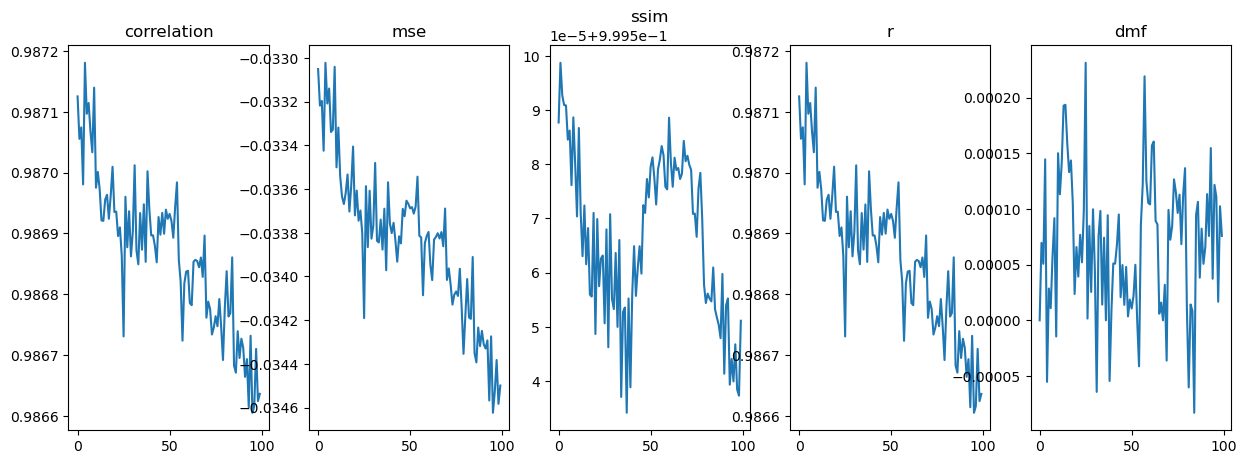

In [21]:
fig, axs = plt.subplots(1,5,figsize=(15,5))
for i, key in enumerate(metrics.keys()):
    axs[i].plot(metrics[key])
    axs[i].set_title(key)

### register the whole recording

In [29]:
#locally
import register
importlib.reload(register)
from register import save_register_recipe, register_recording, registered_volume_reader
save_register_recipe(paths, 
                     recipe=recipe,
                     ref_vol=ref_vol,
                     crop = crop,
                     eye_mask=None,
                     vid_params = {"write_video": True,
                                   "write_dff_video": True,
                                   "fps": 30,
                                   "vid": {"vmax": 20,
                                           "vmin": 0,
                                           "absolute_limits": True},
                                   "dff": {"vmax": 10,
                                           "vmin": -10,
                                           "absolute_limits": True,
                                           "tau": 10,},
                                   "zpos": None,
                                   "scalebar": 200,
                                   "transpose": True},

                    )

Recipe saved to /home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/reg_recipe.yaml


In [30]:
#locally
register_recording(paths)


Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

metrics
Writing video to /home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/registered_T_vmin0-vmax20_al.mp4
Writing dff video to /home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/registered_dff_T_vmin-10-vmax10_al.mp4


Registering:   0%|          | 0/4020 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Levels:   0%|          | 0/4 [00:00<?, ?it/s]

Repeats:   0%|          | 0/1 [00:00<?, ?it/s]

Repeats:   0%|          | 0/10 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#on the cluster 
email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='deconv'+paths.dataset_name, conda_env='lfm1',
                                     time="0-12:00", partition="gpu", gres="gpu:1", cpus_per_task=16,mem='128G',ntasks=1,nodes=1,exclude="s-sc-pgpu03",
                                     cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')

In [ ]:
job_id = slex.submit(register_recording, paths)
print(paths.dataset_name)

### Analysis

In [34]:
reg = lazyh5(paths.registered)
re

{'test': 1}

In [32]:
import register, video
importlib.reload(register)
from register import save_register_recipe, register_recording, registered_volume_reader
regreader = registered_volume_reader(paths, idx=np.arange(1,20,1))


0it [00:00, ?it/s]

(1, array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.10795094e-13, 1.30038314e-13, 1.53902390e-13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.36773750e-13, 6.49323585e-13, 7.95040032e-13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [8.84088054e-19, 1.02498648e-18, 1.09389115e-18, ...,
         2.30285854e-15, 2.17291670e-15, 1.25697042e-15],
        [6.72679508e-19, 7.70449257e-19, 9.31001189e-19, ...,
         2.18151324e-15, 2.03737449e-15, 1.17864698e-15],
        [5.44110515e-19, 5.60434717e-19, 5.92385447e-19, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.11975513e-13, 1.34654888e-13, 1.63290591e-13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.81882167e-